# Lachesis Stop Detection

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm insipired by the one in _Project Lachesis: Parsing and Modeling Location Histories_ (Hariharan & Toyama). This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration. 

* Roaming distance represents the maximum distance an object can move away from a point location and still be considered to be staying at that location.
* Stop duration is the minimum amount of time an object must spend within the roaming distance of a location to qualify as a stop.

The algorithm identifies stops as contiguous sequences of pings that stay within the roaming distance for at least the duration of the stop duration.

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```dur_min```: Minimum duration for a stay in minutes.
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).
* ```delta_roam```: Maximum roaming distance for a stay in meters.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Imports
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import box
from nomad.stop_detection.viz import plot_stops_barcode, plot_time_barcode, plot_stops, plot_pings
import nomad.stop_detection.lachesis as LACHESIS
import nomad.data as data_folder
from pathlib import Path

# Load data
data_dir = Path(data_folder.__file__).parent
city = gpd.read_parquet(data_dir / 'garden-city-buildings-mercator.parquet')
outer_box = box(*city.total_bounds)

filepath_root = 'gc_data_long/'
tc = {"user_id": "gc_identifier", "x": "dev_x", "y": "dev_y", "timestamp": "unix_ts"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters=('date','==', '2024-01-01'), traj_cols=tc)

# Lachesis (sequential stop detection)
stops = LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)

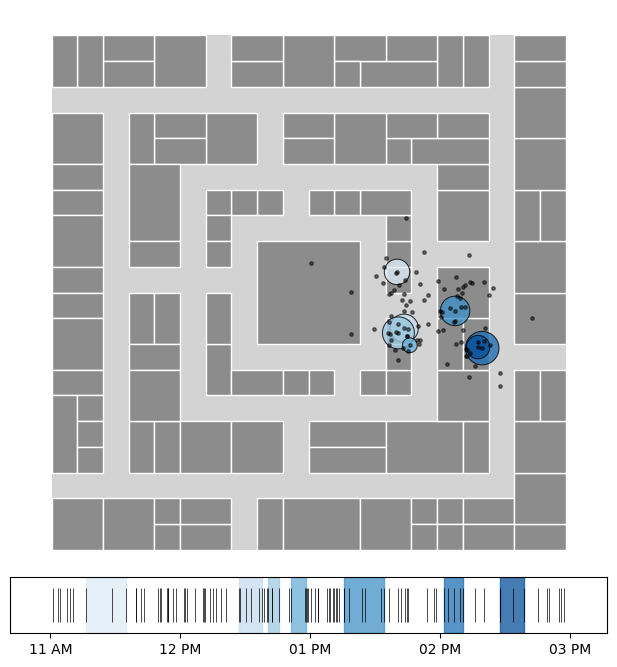

In [2]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

gpd.GeoDataFrame(geometry=[outer_box], crs='EPSG:3857').plot(ax=ax_map, color='#d3d3d3')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#8c8c8c')

plot_stops(stops, ax=ax_map, cmap='Blues')
plot_pings(traj, ax=ax_map, s=6, color='black', alpha=0.5, traj_cols=tc)
ax_map.set_axis_off()

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops, ax=ax_barcode, cmap='Blues', set_xlim=False, timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()